# Video game Logistic Regression - resample - EU from NA and JP
This notebook uses a Logistic Regression ML model to predict EU Sales based on Platform, Genre, NA_Sales, and JP_Sales. The notebook sets the threshold for EU_Sales to some value independent of the median value of EU_Sales and investigates oversampling, undersampling, and combination sampling to balance the yes/no values for EU_Sales. To reduce the number of data points, this code sets a lower threshold for the data to include in the analysis. The data also excludes outliers.

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

## Read in data and remove unnecessary columns

In [2]:
# Import data
path = "resources/vgsales.csv"
vg_sales_df = pd.read_csv(path)
vg_sales_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
vg_sales_df.shape

(16598, 11)

In [4]:
include_sales_threshold = 0.1
vg_sales_df[vg_sales_df["Global_Sales"] < include_sales_threshold].count()

Rank            5781
Name            5781
Platform        5781
Year            5678
Genre           5781
Publisher       5755
NA_Sales        5781
EU_Sales        5781
JP_Sales        5781
Other_Sales     5781
Global_Sales    5781
dtype: int64

In [5]:
# Drop rows where Global_Sales < include_sales_threshold
vg_sales_df = vg_sales_df[vg_sales_df.Global_Sales > include_sales_threshold]

In [6]:
# Run statistics on Global Sales data
vg_sales_df.Global_Sales.describe()

count    10417.000000
mean         0.827790
std          1.904258
min          0.110000
25%          0.190000
50%          0.360000
75%          0.790000
max         82.740000
Name: Global_Sales, dtype: float64

In [7]:
mean = vg_sales_df.Global_Sales.mean()
first_quartile = vg_sales_df.Global_Sales.quantile(0.25)
third_quartile = vg_sales_df.Global_Sales.quantile(0.75)
IQR = third_quartile-first_quartile
upper_outlier_IQR = third_quartile + 1.5*IQR
lower_outlier_IQR = first_quartile - 1.5*IQR

print(f"Upper Outlier: {upper_outlier_IQR}")
print(f"Lower Outlier: {lower_outlier_IQR}")

Upper Outlier: 1.6900000000000002
Lower Outlier: -0.7100000000000002


In [8]:
std_dev = vg_sales_df.Global_Sales.std()

upper_outlier_std = mean + 3*std_dev
lower_outlier_std = mean - 3*std_dev

print(f"Upper Outlier: {upper_outlier_std}")
print(f"Lower Outlier: {lower_outlier_std}")

Upper Outlier: 6.54056431973041
Lower Outlier: -4.884984018299995


In [9]:
vg_sales_df[vg_sales_df["Global_Sales"] < upper_outlier_std].count()

Rank            10290
Name            10290
Platform        10290
Year            10128
Genre           10290
Publisher       10259
NA_Sales        10290
EU_Sales        10290
JP_Sales        10290
Other_Sales     10290
Global_Sales    10290
dtype: int64

In [10]:
# Drop rows where Global_Sales < include_sales_threshold
vg_sales_df = vg_sales_df[vg_sales_df.Global_Sales < upper_outlier_std]

In [11]:
vg_sales_df.shape

(10290, 11)

In [12]:
vg_sales_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
127,128,The Legend of Zelda,NES,1986.0,Action,Nintendo,3.74,0.93,1.69,0.14,6.51
128,129,Assassin's Creed III,PS3,2012.0,Action,Ubisoft,2.64,2.56,0.16,1.14,6.50
129,130,Halo: Combat Evolved,XB,2001.0,Shooter,Microsoft Game Studios,4.98,1.30,0.08,0.07,6.43
130,131,Pokémon Emerald Version,GBA,2004.0,Role-Playing,Nintendo,2.57,1.58,2.06,0.21,6.41
131,132,Kingdom Hearts,PS2,2002.0,Role-Playing,Sony Computer Entertainment,3.64,1.20,1.49,0.07,6.40


In [13]:
# Drop columns
vg_sales_df.drop(["Name", "Year", "Publisher", "Other_Sales", "Global_Sales"], axis=1, inplace=True)
vg_sales_df.set_index("Rank", inplace=True)
vg_sales_df.head()

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales
Rank,,,,,
128,NES,Action,3.74,0.93,1.69
129,PS3,Action,2.64,2.56,0.16
130,XB,Shooter,4.98,1.30,0.08
131,GBA,Role-Playing,2.57,1.58,2.06
132,PS2,Role-Playing,3.64,1.20,1.49


In [14]:
# Get unique Platform values
vg_sales_df["Platform"].unique()

array(['NES', 'PS3', 'XB', 'GBA', 'PS2', 'GB', 'X360', 'GC', 'SNES', 'PC',
       'PS', 'GEN', 'DS', 'Wii', 'PS4', 'N64', 'PSP', 'WiiU', '3DS',
       'XOne', '2600', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16'],
      dtype=object)

In [15]:
# Make sure there are no null values
vg_sales_df["Platform"].isnull().sum()

0

In [16]:
# Get unique Genre values
vg_sales_df["Genre"].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Platform', 'Fighting',
       'Sports', 'Simulation', 'Puzzle', 'Adventure', 'Racing',
       'Strategy', 'Misc'], dtype=object)

In [17]:
# Make sure there are no null values
vg_sales_df["Genre"].isnull().sum()

0

In [18]:
# Make sure sales columns do not have null values
print(f"NA_Sales has {vg_sales_df['NA_Sales'].isnull().sum()} null values.")
print(f"EU_Sales has {vg_sales_df['EU_Sales'].isnull().sum()} null values.")
print(f"JP_Sales has {vg_sales_df['JP_Sales'].isnull().sum()} null values.")

NA_Sales has 0 null values.
EU_Sales has 0 null values.
JP_Sales has 0 null values.


In [19]:
# Write reduced df to csv
# vg_sales_df.to_csv('resources/vgsales_reduced_NA_and_EU.csv')

## Histogram of Sales Data

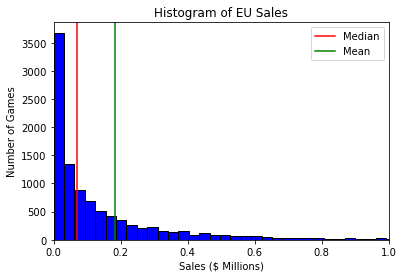

The median sales for EU is $0.07 Million


In [20]:
# Create Histogram to view NA Sales distribution
plt.hist(vg_sales_df['EU_Sales'], color = 'blue', edgecolor = 'black',
         bins = 200)
plt.title('Histogram of EU Sales')
plt.xlabel('Sales ($ Millions)')
plt.ylabel('Number of Games')
plt.xlim(left=0, right=1)
plt.axvline(vg_sales_df['EU_Sales'].median(),label="Median",color='red')
plt.axvline(vg_sales_df['EU_Sales'].mean(),label="Mean",color='green')
plt.legend()
plt.show()

print(f"The median sales for EU is ${round(vg_sales_df['EU_Sales'].median(),3)} Million")

## Categorize Other_Sales Column

In [21]:
# Copy vg_sales_df
categorize_eu_sales = vg_sales_df.filter(["EU_Sales"], axis=1)
categorize_eu_sales

,EU_Sales
Rank,
128,0.93
129,2.56
130,1.30
131,1.58
132,1.20
...,...
10414,0.00
10415,0.04
10416,0.03


## Set Threshold Sales Number

In [22]:
# Set threshold sales number
# na_sales_threshold = round(sales_data_nrm['NA_Sales'].median(),3)
eu_sales_threshold = 0.2

In [23]:
# Reassign NA_sales value
for index,row in categorize_eu_sales.iterrows():
    
    # NA Sales
    if row.EU_Sales > eu_sales_threshold:
        categorize_eu_sales.loc[index] = 1
    else:
        categorize_eu_sales.loc[index] = 0

eu_sales_col_name = "EU_Sales_gt_" + str(eu_sales_threshold)
categorize_eu_sales.\
    rename(columns={"EU_Sales": eu_sales_col_name}, inplace=True)

categorize_eu_sales.head()

,EU_Sales_gt_0.2
Rank,
128,1.0
129,1.0
130,1.0
131,1.0
132,1.0


In [24]:
# Write categorized df to csv file
# output_file_str = "EU_Sales_nrm_thresh_" + \
#     str(eu_sales_threshold).split(".")[0] + "p" + str(eu_sales_threshold).split(".")[1] + ".csv"
# categorize_eu_sales.to_csv('resources/' + output_file_str)

## Separate Sales Data for NA and JP

In [25]:
sales_data = vg_sales_df.filter(["NA_Sales", "JP_Sales"], axis=1)
sales_data.head()

,NA_Sales,JP_Sales
Rank,,
128,3.74,1.69
129,2.64,0.16
130,4.98,0.08
131,2.57,2.06
132,3.64,1.49


In [26]:
# Create platform df
platform_df = vg_sales_df.filter(["Platform"], axis=1)
platform_df.head()

,Platform
Rank,
128,NES
129,PS3
130,XB
131,GBA
132,PS2


## Encode Platform data

In [27]:
# Encode platform df
platform_encoded_df = pd.get_dummies(platform_df)
platform_encoded_df.head()

,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_N64,Platform_NES,...,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
Rank,,,,,,,,,,,,,,,,,,,,,
128,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
131,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Get shape of platform_encoded_df
platform_encoded_df.shape

(10290, 28)

In [29]:
# Write encoded platform data to CSV
# platform_encoded_df.to_csv('resources/encoded_platform.csv')

## Encode Genre data

In [30]:
# Create genre df
genre_df = vg_sales_df.filter(["Genre"], axis=1)
genre_df.head()

,Genre
Rank,
128,Action
129,Action
130,Shooter
131,Role-Playing
132,Role-Playing


In [31]:
# Encode genre df
genre_encoded_df = pd.get_dummies(genre_df)
genre_encoded_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,
128,1,0,0,0,0,0,0,0,0,0,0,0
129,1,0,0,0,0,0,0,0,0,0,0,0
130,0,0,0,0,0,0,0,0,1,0,0,0
131,0,0,0,0,0,0,0,1,0,0,0,0
132,0,0,0,0,0,0,0,1,0,0,0,0


In [32]:
# Get shape of genre_encoded_df
genre_encoded_df.shape

(10290, 12)

In [33]:
# Write encoded genre data to CSV
# genre_encoded_df.to_csv('resources/encoded_genre.csv')

## Combine dataframes for analysis

In [34]:
# Combine dataframes to create sales_df_encoded
sales_df_encoded = categorize_eu_sales.join(sales_data, how='outer').\
    join(platform_encoded_df, how='outer').join(genre_encoded_df, how='outer')
sales_df_encoded.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
128,1.0,3.74,1.69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,1.0,2.64,0.16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,1.0,4.98,0.08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
131,1.0,2.57,2.06,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
132,1.0,3.64,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [35]:
# Create smaller df of 100 rows selected randomly from larger dataset
# sales_reduced = sales_df_encoded.sample(n=9000)
# sales_reduced.head()

sales_reduced = sales_df_encoded.copy()
sales_reduced.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
128,1.0,3.74,1.69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,1.0,2.64,0.16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,1.0,4.98,0.08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
131,1.0,2.57,2.06,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
132,1.0,3.64,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [36]:
sales_reduced.shape

(10290, 43)

In [37]:
# Drop the index
sales_reduced_no_idx = sales_reduced.reset_index(drop=True)
sales_reduced_no_idx.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,1.0,3.74,1.69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.64,0.16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,4.98,0.08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,2.57,2.06,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,3.64,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Perform ML with Logistic Regression

In [38]:
# Count True/False NA_Sales numbers
sales_reduced_no_idx[eu_sales_col_name].value_counts()

0.0    7756
1.0    2534
Name: EU_Sales_gt_0.2, dtype: int64

In [39]:
# Set X and y data
y = sales_reduced_no_idx[eu_sales_col_name]
X = sales_reduced_no_idx.drop(columns=eu_sales_col_name)

In [40]:
# Split data into training and testing data
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
# X_train.shape
Counter(y_train)

Counter({1.0: 1900, 0.0: 5817})

### Oversample data

Random Oversampling

In [41]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({1.0: 5817, 0.0: 5817})

In [42]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [43]:
# Train the model
# classifier.fit(X_train, y_train)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [44]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0
5,1.0,1.0
6,1.0,1.0
7,0.0,0.0
8,0.0,0.0
9,1.0,1.0


In [45]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8344345122425184


In [46]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8073480915558606

In [47]:
# # Print confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1669,270
Actual > threshold,156,478


In [48]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      1939
         1.0       0.64      0.75      0.69       634

    accuracy                           0.83      2573
   macro avg       0.78      0.81      0.79      2573
weighted avg       0.85      0.83      0.84      2573



In [49]:
print('Train Score: ', classifier.score(X_resampled, y_resampled))  
print('Test Score: ', classifier.score(X_test, y_test)) 

Train Score:  0.821471548908372
Test Score:  0.8344345122425184
